In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

## Load Data

In [3]:
# load data
ReutersDF = pandas.read_csv('Reuters_2017News.csv')
ReutersDF.rename(columns ={'Topic': 'category'}, inplace=True)
ReutersDF[:3]
target_categories = ['economy', 'environment', 'entertainment']

# normalize
ReutersDF['tokenized_text'] = ReutersDF['News'].apply(lambda x: nltk.word_tokenize(x))
ReutersDF['normalized_text'] = ReutersDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [3]:
ReutersDF[:3]

,Unnamed: 0,Year,Month,Day,Title,category,News,Link,tokenized_text,normalized_text
0,0,2008,12,1,"Earthquake rattles Taiwan, no reports of damage",environment,Reuters Staff1 Min ReadTAIPEI (Reuters) - An e...,http://www.reuters.com/article/environmentNews...,"[Reuters, Staff1, Min, ReadTAIPEI, (, Reuters,...","[reuter, min, readtaipei, reuter, earthquak, m..."
1,1,2008,12,1,TREASURIES-Rise in Asia after Bernanke talks o...,economy,Reuters Staff3 Min Read * Treasuries edge up i...,http://www.reuters.com/article/companyNewsAndP...,"[Reuters, Staff3, Min, Read, *, Treasuries, ed...","[reuter, min, read, treasuri, edg, asia, ralli..."
2,2,2008,12,1,GLOBAL MARKETS-Asia stocks slide as global out...,economy,Reuters Staff4 Min Read * Asian shares fall 3-...,http://www.reuters.com/article/companyNewsAndP...,"[Reuters, Staff4, Min, Read, *, Asian, shares,...","[reuter, min, read, asian, share, fall, pct, w..."


## Train the Model

In [5]:
# split the train and test
holdBackFraction = .2
train_Reuters, test_Reuters = lucem_illud.trainTestSplit(ReutersDF, holdBackFraction=holdBackFraction)
print(len(train_Reuters))
print(len(test_Reuters))

# Train 
# (1) TF-IDF
TFVectorizer_Reuters = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_Reuters = TFVectorizer_Reuters.fit_transform(train_Reuters['News'])
train_Reuters['vect'] = [np.array(v).flatten() for v in TFVects_Reuters.todense()]



# (2) Train the model
MultinomialNB_Reuters = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_Reuters.fit(np.stack(train_Reuters['vect'], axis = 0), train_Reuters['category'])

# (3) Save testing predictions to the dataframe train_Reuters
train_Reuters['nb_predict_NB'] = MultinomialNB_Reuters.predict(np.stack(train_Reuters['vect'], axis=0))
print("Training score:")
print(MultinomialNB_Reuters.score(np.stack(train_Reuters['vect'], axis=0), train_Reuters['category']))
train_Reuters[['category', 'nb_predict_NB']][:10]

1614
403
Training score:
0.8866171003717472


,category,nb_predict_NB
208,economy,economy
708,economy,economy
731,economy,economy
1231,economy,economy
610,economy,economy
330,economy,economy
15,environment,environment
1266,economy,economy
1201,economy,economy
239,economy,economy


In [6]:
# PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_Reuters['vect'], axis=0))

In [7]:
reduced_data[:,0]

array([-0.01940411, -0.03530287, -0.01562035, ..., -0.00602191,
        0.02566433, -0.00602191])

In [62]:
# store the PCA space vectors in the dataframe
train_Reuters['pca'] = [r for r in reduced_data]

In [63]:
train_Reuters['category'][0]

'environment'

In [64]:
train_Reuters['TorF'] = train_Reuters['category']
train_Reuters.loc[train_Reuters['TorF']!=train_Reuters['nb_predict_NB'], 'TorF']=False
train_Reuters.loc[train_Reuters['TorF'] == train_Reuters['nb_predict_NB'], 'TorF']=True




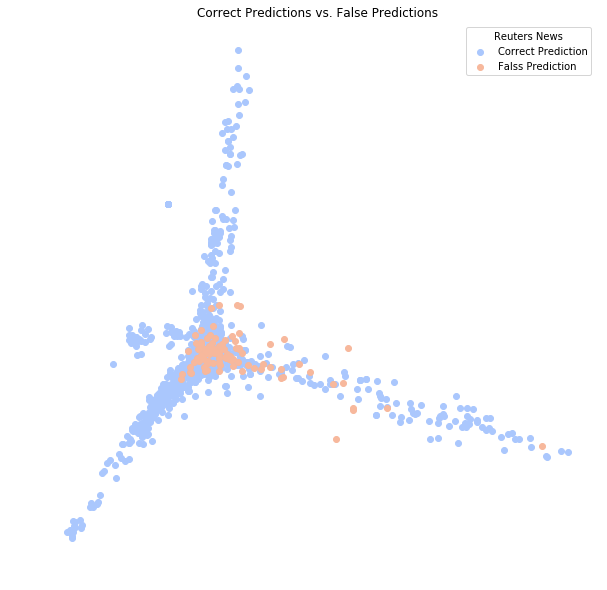

In [65]:
from pylab import figure, axes, pie, title, show

fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

# plot true predictions
a = np.stack(train_Reuters[train_Reuters['TorF']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "Correct Prediction")

a = np.stack(train_Reuters[train_Reuters['TorF'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "Falss Prediction")

ax.legend(loc = 'upper right', title = 'Reuters News')
plt.title('Correct Predictions vs. False Predictions')
plt.show()


## Fit/ Test the Model

In [66]:
#Create vectors
TFVects_test = TFVectorizer_Reuters.transform(test_Reuters['News'])
test_Reuters['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_Reuters['nb_predict_NB'] = MultinomialNB_Reuters.predict(np.stack(test_Reuters['vect'], axis=0))


## Evaluation

In [67]:
# (1) Test score
print("Testing score:")
print(MultinomialNB_Reuters.score(np.stack(test_Reuters['vect'], axis=0), test_Reuters['category']))

Testing score:
0.8560794044665012


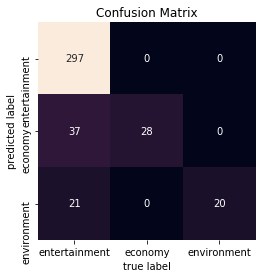

In [68]:
# (2) confusion matrix
lucem_illud.plotConfusionMatrix(MultinomialNB_Reuters, test_Reuters)

In [69]:
# (3) Let's calculate the precision, recall, and F-measures.
print(sklearn.metrics.precision_score(test_Reuters['nb_predict_NB'], test_Reuters['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_Reuters['nb_predict_NB'], test_Reuters['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_Reuters['nb_predict_NB'], test_Reuters['category'], average = 'weighted')) #F-1 measure

0.9350313548945759
0.8560794044665012
0.8769112023595461


In [70]:
# (4) Performance table
lucem_illud.metrics.evaluateClassifier(MultinomialNB_Reuters, test_Reuters)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
economy,0.726415,0.836620,0.143921,0.83662,1.000000
environment,0.743902,0.539914,0.052109,1.00000,0.487805
entertainment,0.715385,0.522581,0.091811,1.00000,0.430769


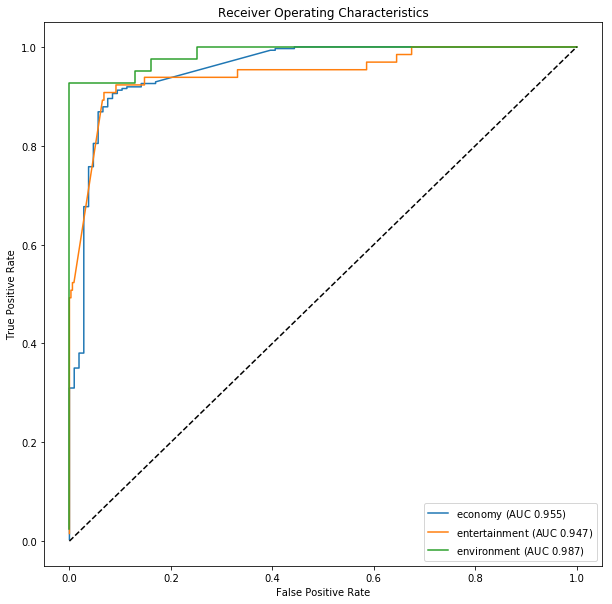

In [71]:
# ROC curve
lucem_illud.plotMultiROC(MultinomialNB_Reuters, test_Reuters)

In [ ]:
clf = sklearn.naive_bayes.GaussianNB()
lucem_illud.plotregions(clf, train_Reuters)

In [ ]:
mycolor = ['orange','green','blue']
plt.figure(figsize = (15,6))

# True Cluster
plt.subplot(131)

animation = plt.scatter(reduced_data[colors.index('blue'):colors.index('green')-1, 0], 
                   reduced_data[colors.index('blue'):colors.index('green')-1, 1], color=mycolor[1],alpha = 0.5)
action = plt.scatter(reduced_data[colors.index('green'):colors.index('orange')-1, 0], 
                   reduced_data[colors.index('green'):colors.index('orange')-1, 1], color=mycolor[2],alpha = 0.5)
crime = plt.scatter(reduced_data[colors.index('orange'):, 0], 
                   reduced_data[colors.index('orange'):, 1], color=mycolor[3],alpha = 0.5)
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('True Clusters\n k = 4')

# Predicted Cluster 4 clusters
plt.subplot(132)
colors_p = [colordict[category[l]] for l in km.labels_]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('Predicted Clusters\n k = 4')

# Predicted Cluster 3 clusters
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(MovieTFVects.toarray())
#Movie_Kingdom['Kmeans Prediction 3'] = km3.labels_
plt.subplot(133)
colors_p3 = [colordict[category[l]] for l in km3.labels_]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p3, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')

plt.figure(figsize = (15,6))
plt.tight_layout()
plt.show()



train_Reuters[['category', 'nb_predict_NB','nb_predict_K']][:10]

KeyError: 'nb_predict_K'

In [14]:
train_Reuters['nb_predict_NB'][0] = 'econ' 

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
train_Reuters['nb_predict_NB'][0] = 'economy'

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
if train_Reuters['nb_predict_NB'][0] == 'economy':
    train_R['NB'][0] = 0

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
train_R['NB'][0]

0

In [17]:
train_Reuters['nb_predict_NB'][0] = 1

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
train_Reuters['nb_predict_NB'][0]

1

In [48]:
#Top indices
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_Reuters['vect'], axis=0), train_Reuters['category'])
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Economy' : [],
    'Economy_log_prob' : [],
    'Entertainment' : [],
    'Entertainment_log_prob' : [],
    'Environment' : [],
    'Environment_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Economy'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Economy_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Entertainment'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Entertainment_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Environment'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Environment_log_prob'].append(prob)
pandas.DataFrame(words_dict)

ValueError: too many values to unpack (expected 2)

In [49]:
clf = sklearn.naive_bayes.GaussianNB()

In [ ]:
train_Reuters

In [52]:
train_Reuters[:3]

,Unnamed: 0,Year,Month,Day,Title,category,News,Link,tokenized_text,normalized_text,vect,nb_predict,pca,TorF
658,658,2008,12,7,"Italy mob drama ""Gomorra"" rules Europe film aw...",entertainment,2 Min ReadCOPENHAGEN (Reuters) - The Italian m...,http://www.reuters.com/article/entertainmentNe...,"[2, Min, ReadCOPENHAGEN, (, Reuters, ), -, The...","[min, readcopenhagen, reuter, italian, mafia, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",entertainment,"[0.037894716475448655, -0.04796261300642952, 0...",True
1747,1747,2008,12,18,Fed refrains from open market operations so far,economy,"Reuters Staff1 Min Read NEW YORK, Dec 18 (Reut...",http://www.reuters.com/article/companyNewsAndP...,"[Reuters, Staff1, Min, Read, NEW, YORK, ,, Dec...","[reuter, min, read, new, york, dec, reuter, fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",economy,"[-0.030065233690985103, 0.015332467858707627, ...",True
1224,1224,2008,12,12,Top Electronic Albums for the 12/20/2008 issue,entertainment,Reuters Staff1 Min Read,http://www.reuters.com/article/billboardCharts...,"[Reuters, Staff1, Min, Read]","[reuter, min, read]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",economy,"[0.003726399592984886, -0.004046471572743089, ...",False


In [ ]:
ReutersDF['category_index'] = ReutersDF['category']
for i in range(0, len(ReutersDF)):
    if ReutersDF['category'][i] == 'economy':
        ReutersDF['category_index'][i] = 1 

    
    

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Knearest

In [27]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [28]:
clf_knearest.fit(np.stack(train_Reuters['vect'], axis = 0), train_Reuters['category'])
lucem_illud.evaluateClassifier(clf_knearest, train_Reuters)
TFVects_test = TFVectorizer_Reuters.transform(test_Reuters['News'])
test_Reuters['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]
#Add to df
test_Reuters['nb_predict_K'] = clf_knearest.predict(np.stack(test_Reuters['vect'], axis=0))
#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_Reuters['vect'], axis=0), test_Reuters['category']))



/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing score:
0.5533498759305211


In [29]:

# (3) Save testing predictions to the dataframe train_Reuters
train_Reuters['nb_predict_K'] = clf_knearest.predict(np.stack(train_Reuters['vect'], axis=0))
print("Training score:")
print(clf_knearest.score(np.stack(train_Reuters['vect'], axis=0), train_Reuters['category']))
train_Reuters[['category', 'nb_predict_NB','nb_predict_K']][:10]

Training score:
0.6332094175960347


,category,nb_predict_NB,nb_predict_K
208,economy,economy,entertainment
708,economy,economy,economy
731,economy,economy,entertainment
1231,economy,economy,economy
610,economy,economy,economy
330,economy,economy,entertainment
15,environment,environment,entertainment
1266,economy,economy,entertainment
1201,economy,economy,economy
239,economy,economy,entertainment


In [18]:
train_Reuters[['category', 'nb_predict_NB','nb_predict_K']][:20]

,category,nb_predict_NB,nb_predict_K
823,economy,economy,economy
1258,economy,economy,economy
1021,entertainment,entertainment,entertainment
948,economy,economy,economy
1139,environment,environment,entertainment
1003,entertainment,entertainment,entertainment
425,entertainment,entertainment,entertainment
1860,entertainment,economy,entertainment
1950,economy,economy,economy
318,economy,economy,economy


In [41]:
train_R = train_Reuters
train_R['NB']=train_Reuters['nb_predict_NB']
train_R.loc[train_R.nb_predict_NB == 'economy', 'NB'] = 0
train_R.loc[train_R.nb_predict_NB == 'entertainment', 'NB'] = 1
train_R.loc[train_R.nb_predict_NB == 'environment', 'NB'] = 2

train_R['K']=train_Reuters['nb_predict_K']
train_R.loc[train_R.nb_predict_K == 'economy', 'K'] = 0
train_R.loc[train_R.nb_predict_K == 'entertainment', 'K'] = 1
train_R.loc[train_R.nb_predict_K == 'environment', 'K'] = 2

train_R['C']=train_Reuters['category']
train_R.loc[train_R.category == 'economy', 'C'] = 0
train_R.loc[train_R.category == 'entertainment', 'C'] = 1
train_R.loc[train_R.category == 'environment', 'C'] = 2

colordict = {
'economy': 'orange',
'environment': 'green',
'entertainment': 'blue',
    }



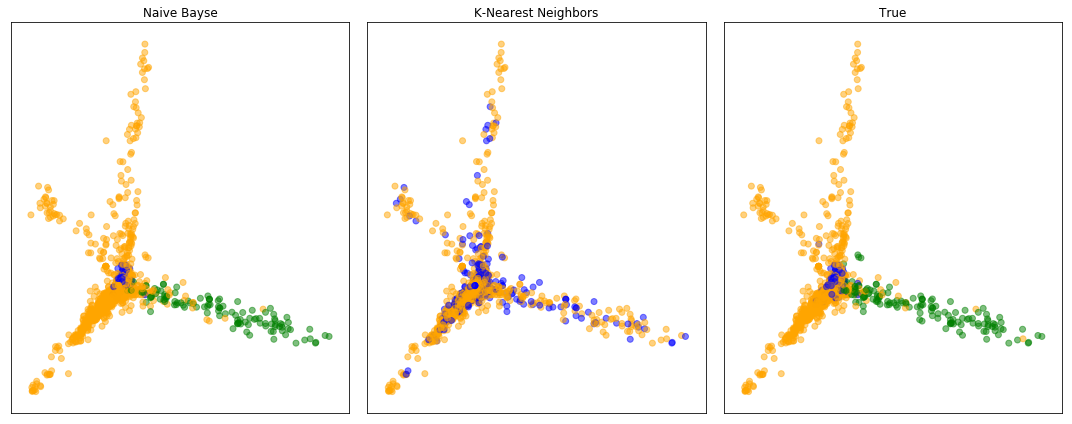

In [42]:
target_categories = ['economy',  'entertainment','environment']
plt.figure(figsize = (15,6))




plt.subplot(131)
colors_p1 = [colordict[target_categories[l]] for l in train_R['NB']]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p1, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Naive Bayse')



plt.subplot(132)
colors_p2 = [colordict[target_categories[l]] for l in train_R['K']]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p2, alpha = 0.5)
plt.xticks(())
plt.yticks(())
#plt.legend((economy, entertainment, environment),
#          ('economy',  'entertainment','environment'),
#          scatterpoints=1,
#          loc = 'upper right',
#          ncol =2,
#          fontsize = 8)
plt.title('K-Nearest Neighbors')


plt.subplot(133)
colors_p3 = [colordict[target_categories[l]] for l in train_R['C']]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p3, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('True')

plt.tight_layout()
plt.show()

In [ ]:
train_Reuters[['category', 'nb_predict_NB']][:10]

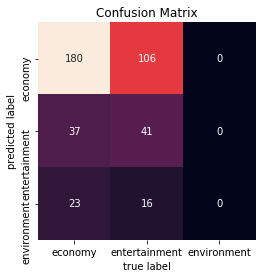

In [10]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_Reuters)

In [ ]:
MultinomialNB_Reuters = sklearn.naive_bayes.MultinomialNB()
lucem_illud.plotregions(MultinomialNB_Reuters, test_Reuters)

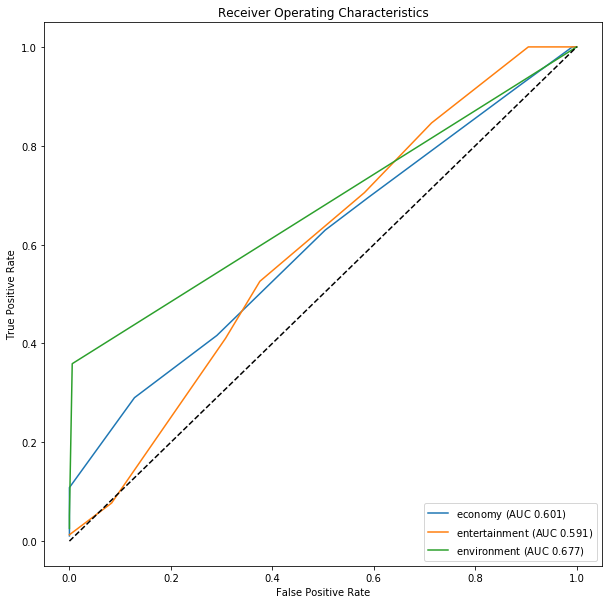

In [11]:
# ROC curve
lucem_illud.plotMultiROC(clf_knearest, test_Reuters)

In [12]:
lucem_illud.metrics.evaluateClassifier(clf_knearest, test_Reuters)

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
economy,0.558275,0.735055,0.411911,0.750000,0.629371
entertainment,0.575128,0.224028,0.394541,0.251534,0.525641
environment,0.500000,0.096774,0.096774,0.000000,0.000000


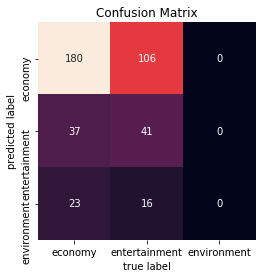

In [13]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_Reuters)

KeyError: 'category_index'

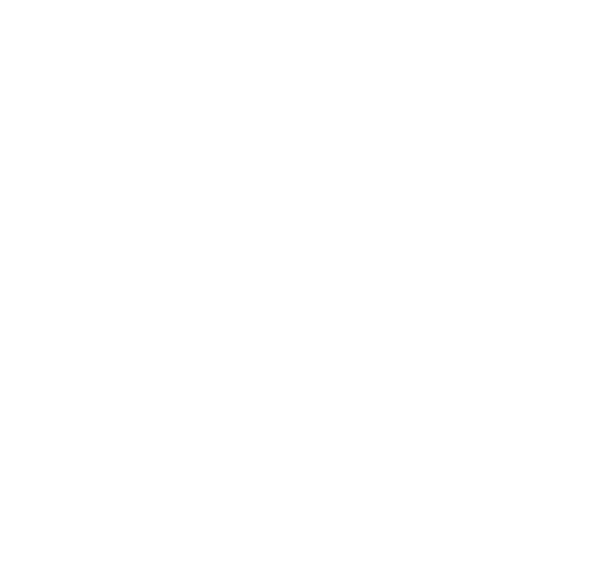

In [51]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

# plot economy 1
a1 = np.stack(train_Reuters[train_Reuters['category_index']==1]['pca'])
ax.scatter(a1[:,0], a1[:, 1], c = pallet[0], label = "Economy")

# plot entertainment 2
a2 = np.stack(train_Reuters[train_Reuters['category_index']==2]['pca'])
ax.scatter(a2[:,0], a2[:, 1], c = pallet[1], label = "Entertainment")

# plot environment 3
a3 = np.stack(train_Reuters[train_Reuters['category_index']==3]['pca'])
ax.scatter(a3[:,0], a3[:, 1], c = pallet[2], label = "Environment")

plt.title('Correct Predictions vs. False Predictions')
plt.show()

In [72]:
ReutersDF[:3]

,Unnamed: 0,Year,Month,Day,Title,category,News,Link,tokenized_text,normalized_text
0,0,2008,12,1,"Earthquake rattles Taiwan, no reports of damage",environment,Reuters Staff1 Min ReadTAIPEI (Reuters) - An e...,http://www.reuters.com/article/environmentNews...,"[Reuters, Staff1, Min, ReadTAIPEI, (, Reuters,...","[reuter, min, readtaipei, reuter, earthquak, m..."
1,1,2008,12,1,TREASURIES-Rise in Asia after Bernanke talks o...,economy,Reuters Staff3 Min Read * Treasuries edge up i...,http://www.reuters.com/article/companyNewsAndP...,"[Reuters, Staff3, Min, Read, *, Treasuries, ed...","[reuter, min, read, treasuri, edg, asia, ralli..."
2,2,2008,12,1,GLOBAL MARKETS-Asia stocks slide as global out...,economy,Reuters Staff4 Min Read * Asian shares fall 3-...,http://www.reuters.com/article/companyNewsAndP...,"[Reuters, Staff4, Min, Read, *, Asian, shares,...","[reuter, min, read, asian, share, fall, pct, w..."


In [73]:
ReutersDF['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in ReutersDF['normalized_text']]

In [74]:
ReutersDF_WordtoPOS = nltk.ConditionalFreqDist(ReutersDF['normalized_tokens_POS'].sum())
list(ReutersDF_WordtoPOS.items())[:10]

[('reuter',
  FreqDist({'JJ': 75,
            'JJR': 53,
            'NN': 3416,
            'RB': 4,
            'VB': 2,
            'VBD': 3,
            'VBP': 52})),
 ('min', FreqDist({'JJ': 107, 'NN': 1833, 'NNS': 26, 'RBS': 61})),
 ('readtaipei', FreqDist({'NN': 4})),
 ('earthquak', FreqDist({'NN': 8, 'VB': 1})),
 ('measur',
  FreqDist({'CC': 1,
            'CD': 1,
            'FW': 11,
            'JJ': 54,
            'NN': 228,
            'NNS': 33,
            'RB': 5,
            'RBS': 2,
            'VB': 2,
            'VBD': 7,
            'VBN': 1,
            'VBP': 9,
            'VBZ': 2})),
 ('richter', FreqDist({'NN': 2})),
 ('scale', FreqDist({'JJ': 11, 'NN': 45, 'VBP': 2})),
 ('shook', FreqDist({'NN': 5, 'VBD': 1})),
 ('southern', FreqDist({'JJ': 43})),
 ('taiwan',
  FreqDist({'IN': 1,
            'JJ': 9,
            'NN': 21,
            'NNP': 9,
            'NNS': 1,
            'VB': 3,
            'VBD': 2,
            'VBP': 2}))]

In [77]:
ReutersDF_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in ReutersDF['normalized_tokens_POS'].sum())
ReutersDF_POStoWord['NN']

FreqDist({'reuter': 3416,
          'min': 1833,
          'readtaipei': 4,
          'earthquak': 8,
          'measur': 228,
          'richter': 2,
          'scale': 45,
          'shook': 5,
          'taiwan': 21,
          'report': 2316,
          'casualti': 4,
          'damag': 43,
          'offici': 201,
          'struck': 3,
          'gmt': 91,
          'km': 17,
          'mile': 27,
          'northeast': 3,
          'coast': 28,
          'depth': 12,
          'weather': 49,
          'bureau': 16,
          'statement': 313,
          'lie': 16,
          'activ': 76,
          'stretch': 17,
          'pacif': 33,
          'quak': 2,
          'septemb': 119,
          'destroy': 21,
          'ralph': 10,
          'jen': 2,
          'edit': 1262,
          'nick': 20,
          'macfi': 7,
          'asia': 71,
          'day': 935,
          'comment': 272,
          'support': 486,
          'share': 1051,
          'drop': 348,
          'gloom': 30,
    

In [78]:
ReutersDF_POStoWord['JJ']

FreqDist({'southern': 43,
          'tuesday': 371,
          'immedi': 40,
          'epicentr': 1,
          'quak': 1,
          'chenggong': 1,
          'km': 1,
          'central': 549,
          'frequent': 12,
          'seismic': 7,
          'peopl': 94,
          'treasuri': 183,
          'edg': 16,
          'previous': 350,
          'chief': 203,
          'bernank': 12,
          'matur': 17,
          'asian': 100,
          'econom': 300,
          'noguchi': 11,
          'benchmark': 46,
          'low': 604,
          'signal': 39,
          'govern': 936,
          'agenc': 49,
          'big': 332,
          'economi': 276,
          'languish': 4,
          'wall': 110,
          'factori': 34,
          'recess': 69,
          'urg': 70,
          'secur': 96,
          'influenc': 13,
          'stimul': 28,
          'fed': 35,
          'anoth': 27,
          'polici': 82,
          'last': 945,
          'yoshio': 3,
          'takahashi': 3,
          'de

In [ ]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names
 
def word_feats(words):
    return dict([(word, True) for word in words])
 
positive_vocab = [ 'awesome', 'outstanding', 'fantastic', 'terrific', 'good', 'nice', 'great', ':)' ]
negative_vocab = [ 'bad', 'terrible','useless', 'hate', 'low','languish','recession','weak','deepen','inflict','tumble','crude','volatile','inflation','fall','hard','pressure' ]
neutral_vocab = [ 'movie','the','sound','was','is','actors','did','know','words','not' ]